In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf

import numpy as np
import os
import time
import urllib.request
import re
tf.__version__

'2.15.0'

**Предобработка данных**

Токенизация и кодирование

In [ ]:
url = "https://www.gutenberg.org/cache/epub/64317/pg64317.txt"
file = urllib.request.urlopen(url)
text = [line.decode('utf-8') for line in file]
text = ''.join(text)
text = re.sub(' +',' ',text)
text = re.sub(r'[^A-Za-z.,!\r ]+', '', text)
text = text[1140:]
text[:500]

'In my younger and more vulnerable years my father gave me some advice\rthat Ive been turning over in my mind ever since.\r\rWhenever you feel like criticizing anyone, he told me, just\rremember that all the people in this world havent had the advantages\rthat youve had.\r\rHe didnt say any more, but weve always been unusually communicative\rin a reserved way, and I understood that he meant a great deal more\rthan that. In consequence, Im inclined to reserve all judgements, a\rhabit that has opened up many'

Извлечение словаря токенов символов из текста

In [ ]:
vocab = sorted(set(text))
",".join(vocab)

'\r, ,!,,,.,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z'

Кодировка символов и функций отображения

In [ ]:
#Функции отображения char2idx и idx2char отображают символы в индексы и обратно
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])
[f"{char} = {i}" for char,i in zip(char2idx, range(20))]

['\r = 0',
 '  = 1',
 '! = 2',
 ', = 3',
 '. = 4',
 'A = 5',
 'B = 6',
 'C = 7',
 'D = 8',
 'E = 9',
 'F = 10',
 'G = 11',
 'H = 12',
 'I = 13',
 'J = 14',
 'K = 15',
 'L = 16',
 'M = 17',
 'N = 18',
 'O = 19']

Построение обучающих наборов

In [ ]:
#Переменная example_per_epoch — это количество выборок или фрагментов текста, которые мы будем передавать модели. char_dataset — это преобразование кодировок text_as_int в тензоры.
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

[idx2char[i.numpy()] for i in char_dataset.take(5)]

['I', 'n', ' ', 'm', 'y']

Разбиение текста на обучающие последовательности

In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
[repr(''.join(idx2char[item.numpy()])) for item in sequences.take(6)]

["'In my younger and more vulnerable years my father gave me some advice\\rthat Ive been turning over in m'",
 "'y mind ever since.\\r\\rWhenever you feel like criticizing anyone, he told me, just\\rremember that all the'",
 "' people in this world havent had the advantages\\rthat youve had.\\r\\rHe didnt say any more, but weve alwa'",
 "'ys been unusually communicative\\rin a reserved way, and I understood that he meant a great deal more\\rt'",
 "'han that. In consequence, Im inclined to reserve all judgements, a\\rhabit that has opened up many curi'",
 "'ous natures to me and also made me\\rthe victim of not a few veteran bores. The abnormal mind is quick '"]

Создание входной и таргетовой последовательности с помощью простой функции карты

In [ ]:
#Поскольку мы обучаем сеть последовательностям, создадим входную последовательность, а затем таргетовую или целевую.
#При использовании RNN целевой последовательностью будет входная последовательность, смещенная на один символ

@tf.autograph.experimental.do_not_convert
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'In my younger and more vulnerable years my father gave me some advice\rthat Ive been turning over in '
Target data: 'n my younger and more vulnerable years my father gave me some advice\rthat Ive been turning over in m'


Пример входных и ожидаемых выходных данных, к которым будем обучать сеть

In [ ]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 13 ('I')
  expected output: 43 ('n')
Step    1
  input: 43 ('n')
  expected output: 1 (' ')
Step    2
  input: 1 (' ')
  expected output: 42 ('m')
Step    3
  input: 42 ('m')
  expected output: 54 ('y')
Step    4
  input: 54 ('y')
  expected output: 1 (' ')


**Построение и обучение модели**

Гиперпараметры для модели

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024
rnn_units_2 = 512

Создание модели

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim,
                            batch_input_shape=[BATCH_SIZE, None]),
  tf.keras.layers.GRU(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
  tf.keras.layers.GRU(rnn_units_2,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
  tf.keras.layers.Dense(vocab_size)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           14336     
                                                                 
 gru (GRU)                   (64, None, 1024)          3938304   
                                                                 
 gru_1 (GRU)                 (64, None, 512)           2362368   
                                                                 
 dense (Dense)               (64, None, 56)            28728     
                                                                 
Total params: 6343736 (24.20 MB)
Trainable params: 6343736 (24.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Определение функции потерь

In [ ]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss)

Сохранении копии модели для дальнейшего использования

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
epochs = 5

Обучение модели

In [ ]:
history = model.fit(dataset, epochs=epochs, callbacks=[checkpoint_callback])

Epoch 1/5
43/43 [==============================] - 429s 10s/step - loss: 3.0104
Epoch 2/5
43/43 [==============================] - 397s 9s/step - loss: 2.3688
Epoch 3/5
43/43 [==============================] - 413s 10s/step - loss: 2.1493
Epoch 4/5
43/43 [==============================] - 404s 9s/step - loss: 1.9700
Epoch 5/5
43/43 [==============================] - 394s 9s/step - loss: 1.8147


Определение функции для запроса модели и генерации текста

In [ ]:
def generate_text(model, start_string, temp, gen_chars):
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  model.reset_states()
  for i in range(gen_chars):
    predictions = model(input_eval)
    predictions = tf.squeeze(predictions, 0)
    predictions = predictions / temp
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    input_eval = tf.expand_dims([predicted_id], 0)
    text_generated.append(idx2char[predicted_id])
  return (start_string + ''.join(text_generated))

Перестройка модели, используя только 1 вход или батч

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim,
                            batch_input_shape=[1, None]),
  tf.keras.layers.GRU(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
  tf.keras.layers.GRU(rnn_units_2,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
  tf.keras.layers.Dense(vocab_size)
])
model.summary()
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            14336     
                                                                 
 gru_4 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 gru_5 (GRU)                 (1, None, 512)            2362368   
                                                                 
 dense_2 (Dense)             (1, None, 56)             28728     
                                                                 
Total params: 6343736 (24.20 MB)
Trainable params: 6343736 (24.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Генерация текстов разных температур**

Температура используется для определения предсказуемости текста. Более низкая температура (0,25) создает интеллектуальный текст. В то время как более высокая температура (2.0) генерирует более уникальный текст. Более высокие температуры могут привести к бессмысленному тексту.

In [ ]:
text_025 = generate_text(model, u"He said ", .25, 200)

In [ ]:
text_025

'He said Tom some of the same to a cound the sounded a stard the port of the sure of the seem to a stranged that the said and the said and the said and the seem of the supper of the said with a change and the '

In [ ]:
text_05 = generate_text(model, u"She thinks ", 0.5, 200)

In [ ]:
text_05

'She thinks an the though and the tood and went ad a stort with at him eyes that he wildon that we could was a moloning though that was in the and which sat the but the drown the and were coneed thing had be all '

In [ ]:
text_08 = generate_text(model, u"In my younger ", 0.8, 200)

In [ ]:
text_08

'In my younger by the dont mener, the shouldng word but he case gurle sere of Tom name side for going in the shorle it with the suppain she ball, in this husbrad. He counded to arour of that the celloor in so mad in'

In [ ]:
text_1 = generate_text(model, u"I never ", 1.0, 200)

In [ ]:
text_1

'I never thous off with whick and sayy empate had\rinselvices of fine fage of hace with all.\r\rWhat down boing me. \rTo my Saty a was a tranging over itf tle incussisgent towarm a bound bewand nothinging, and boo'

In [ ]:
text_2 = generate_text(model, u"I never ", 2.0, 200)

In [ ]:
text_2

'I never dPSidvelyss hom.\r,\rainuoched byrw a Flbriwn gonicual towlricet, in iqusibudy, ML!jut if QrUBLNQJyo FoI ngittens tergsed\rCrWin MrothrWe MrKfnKers, ym laSchAfth! His yem\rledam izPladevy loughbou wumoul,'

Перплексия и энтропия

Лучше та модель, которая лучше
предсказывает детали тестовой
коллекции (меньше перплексия)


In [ ]:
from nltk import ngrams
from collections import Counter
import math

Для текста с температурой = 0.25



In [ ]:
corpus = text_025

n = 2
ngram_counts = Counter(ngrams(corpus.split(), n))

total_count = sum(ngram_counts.values())
probabilities = {ngram: count/total_count for ngram, count in ngram_counts.items()}


In [ ]:
def calculate_perplexity(probabilities):
    entropy = 0.0
    for prob in probabilities:
        entropy += math.log2(prob)
    perplexity = 2 ** (-entropy / len(probabilities))
    return perplexity

In [ ]:
probs = []

In [ ]:
print("Вероятности биграмм:")
for ngram, prob in probabilities.items():
    print(' '.join(ngram), "->", prob)
    probs.append(prob)

Вероятности биграмм:
He said -> 0.02127659574468085
said Tom -> 0.02127659574468085
Tom some -> 0.02127659574468085
some of -> 0.02127659574468085
of the -> 0.10638297872340426
the same -> 0.02127659574468085
same to -> 0.02127659574468085
to a -> 0.0425531914893617
a cound -> 0.02127659574468085
cound the -> 0.02127659574468085
the sounded -> 0.02127659574468085
sounded a -> 0.02127659574468085
a stard -> 0.02127659574468085
stard the -> 0.02127659574468085
the port -> 0.02127659574468085
port of -> 0.02127659574468085
the sure -> 0.02127659574468085
sure of -> 0.02127659574468085
the seem -> 0.0425531914893617
seem to -> 0.02127659574468085
a stranged -> 0.02127659574468085
stranged that -> 0.02127659574468085
that the -> 0.02127659574468085
the said -> 0.0851063829787234
said and -> 0.06382978723404255
and the -> 0.0851063829787234
seem of -> 0.02127659574468085
the supper -> 0.02127659574468085
supper of -> 0.02127659574468085
said with -> 0.02127659574468085
with a -> 0.0212765957

In [ ]:
probabilities = probs

In [ ]:
perplexity_1 = calculate_perplexity(probabilities)
print("Perplexity:", perplexity_1)

Perplexity: 38.170337712285985


Для текста с температурой = 0.5

In [ ]:
corpus = text_05

n = 2
ngram_counts = Counter(ngrams(corpus.split(), n))

total_count = sum(ngram_counts.values())
probabilities = {ngram: count/total_count for ngram, count in ngram_counts.items()}


In [ ]:
probs = []

In [ ]:
print("Вероятности биграмм:")
for ngram, prob in probabilities.items():
    print(' '.join(ngram), "->", prob)
    probs.append(prob)

Вероятности биграмм:
She thinks -> 0.022222222222222223
thinks an -> 0.022222222222222223
an the -> 0.022222222222222223
the though -> 0.022222222222222223
though and -> 0.022222222222222223
and the -> 0.022222222222222223
the tood -> 0.022222222222222223
tood and -> 0.022222222222222223
and went -> 0.022222222222222223
went ad -> 0.022222222222222223
ad a -> 0.022222222222222223
a stort -> 0.022222222222222223
stort with -> 0.022222222222222223
with at -> 0.022222222222222223
at him -> 0.022222222222222223
him eyes -> 0.022222222222222223
eyes that -> 0.022222222222222223
that he -> 0.022222222222222223
he wildon -> 0.022222222222222223
wildon that -> 0.022222222222222223
that we -> 0.022222222222222223
we could -> 0.022222222222222223
could was -> 0.022222222222222223
was a -> 0.022222222222222223
a moloning -> 0.022222222222222223
moloning though -> 0.022222222222222223
though that -> 0.022222222222222223
that was -> 0.022222222222222223
was in -> 0.022222222222222223
in the -> 0.02

In [ ]:
probabilities = probs

In [ ]:
perplexity_2 = calculate_perplexity(probabilities)
print("Perplexity:", perplexity_2)

Perplexity: 44.29665404576338


Для текста с температурой = 0.8

In [ ]:
corpus = text_08

n = 2
ngram_counts = Counter(ngrams(corpus.split(), n))

total_count = sum(ngram_counts.values())
probabilities = {ngram: count/total_count for ngram, count in ngram_counts.items()}


In [ ]:
probs = []

In [ ]:
print("Вероятности биграмм:")
for ngram, prob in probabilities.items():
    print(' '.join(ngram), "->", prob)
    probs.append(prob)

Вероятности биграмм:
In my -> 0.022727272727272728
my younger -> 0.022727272727272728
younger by -> 0.022727272727272728
by the -> 0.022727272727272728
the dont -> 0.022727272727272728
dont mener, -> 0.022727272727272728
mener, the -> 0.022727272727272728
the shouldng -> 0.022727272727272728
shouldng word -> 0.022727272727272728
word but -> 0.022727272727272728
but he -> 0.022727272727272728
he case -> 0.022727272727272728
case gurle -> 0.022727272727272728
gurle sere -> 0.022727272727272728
sere of -> 0.022727272727272728
of Tom -> 0.022727272727272728
Tom name -> 0.022727272727272728
name side -> 0.022727272727272728
side for -> 0.022727272727272728
for going -> 0.022727272727272728
going in -> 0.022727272727272728
in the -> 0.022727272727272728
the shorle -> 0.022727272727272728
shorle it -> 0.022727272727272728
it with -> 0.022727272727272728
with the -> 0.022727272727272728
the suppain -> 0.022727272727272728
suppain she -> 0.022727272727272728
she ball, -> 0.022727272727272728
ba

In [ ]:
probabilities = probs

In [ ]:
perplexity_3 = calculate_perplexity(probabilities)
print("Perplexity:", perplexity_3)

Perplexity: 44.0


Для текста с температурой = 1

In [ ]:
corpus = text_1

n = 2
ngram_counts = Counter(ngrams(corpus.split(), n))

total_count = sum(ngram_counts.values())
probabilities = {ngram: count/total_count for ngram, count in ngram_counts.items()}


In [ ]:
probs = []

In [ ]:
print("Вероятности биграмм:")
for ngram, prob in probabilities.items():
    print(' '.join(ngram), "->", prob)
    probs.append(prob)

Вероятности биграмм:
I never -> 0.02564102564102564
never thous -> 0.02564102564102564
thous off -> 0.02564102564102564
off with -> 0.02564102564102564
with whick -> 0.02564102564102564
whick and -> 0.02564102564102564
and sayy -> 0.02564102564102564
sayy empate -> 0.02564102564102564
empate had -> 0.02564102564102564
had inselvices -> 0.02564102564102564
inselvices of -> 0.02564102564102564
of fine -> 0.02564102564102564
fine fage -> 0.02564102564102564
fage of -> 0.02564102564102564
of hace -> 0.02564102564102564
hace with -> 0.02564102564102564
with all. -> 0.02564102564102564
all. What -> 0.02564102564102564
What down -> 0.02564102564102564
down boing -> 0.02564102564102564
boing me. -> 0.02564102564102564
me. To -> 0.02564102564102564
To my -> 0.02564102564102564
my Saty -> 0.02564102564102564
Saty a -> 0.02564102564102564
a was -> 0.02564102564102564
was a -> 0.02564102564102564
a tranging -> 0.02564102564102564
tranging over -> 0.02564102564102564
over itf -> 0.02564102564102564

In [ ]:
probabilities = probs

In [ ]:
perplexity_4 = calculate_perplexity(probabilities)
print("Perplexity:", perplexity_4)

Perplexity: 39.000000000000085


Для текста с температурой = 2

In [ ]:
corpus = text_2

n = 2
ngram_counts = Counter(ngrams(corpus.split(), n))

total_count = sum(ngram_counts.values())
probabilities = {ngram: count/total_count for ngram, count in ngram_counts.items()}


In [ ]:
probs = []

In [ ]:
print("Вероятности биграмм:")
for ngram, prob in probabilities.items():
    print(' '.join(ngram), "->", prob)
    probs.append(prob)

Вероятности биграмм:
I never -> 0.034482758620689655
never dPSidvelyss -> 0.034482758620689655
dPSidvelyss hom. -> 0.034482758620689655
hom. , -> 0.034482758620689655
, ainuoched -> 0.034482758620689655
ainuoched byrw -> 0.034482758620689655
byrw a -> 0.034482758620689655
a Flbriwn -> 0.034482758620689655
Flbriwn gonicual -> 0.034482758620689655
gonicual towlricet, -> 0.034482758620689655
towlricet, in -> 0.034482758620689655
in iqusibudy, -> 0.034482758620689655
iqusibudy, ML!jut -> 0.034482758620689655
ML!jut if -> 0.034482758620689655
if QrUBLNQJyo -> 0.034482758620689655
QrUBLNQJyo FoI -> 0.034482758620689655
FoI ngittens -> 0.034482758620689655
ngittens tergsed -> 0.034482758620689655
tergsed CrWin -> 0.034482758620689655
CrWin MrothrWe -> 0.034482758620689655
MrothrWe MrKfnKers, -> 0.034482758620689655
MrKfnKers, ym -> 0.034482758620689655
ym laSchAfth! -> 0.034482758620689655
laSchAfth! His -> 0.034482758620689655
His yem -> 0.034482758620689655
yem ledam -> 0.034482758620689655

In [ ]:
probabilities = probs

In [ ]:
perplexity_5 = calculate_perplexity(probabilities)
print("Perplexity:", perplexity_5)

Perplexity: 29.000000000000032


In [ ]:
perplexity_temp = [perplexity_1, perplexity_2, perplexity_3, perplexity_4, perplexity_5]

In [ ]:
perplexity_temp

[38.170337712285985,
 44.29665404576338,
 44.0,
 39.000000000000085,
 29.000000000000032]

In [ ]:
temp = [0.25, 0.5, 0.8, 1, 2]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


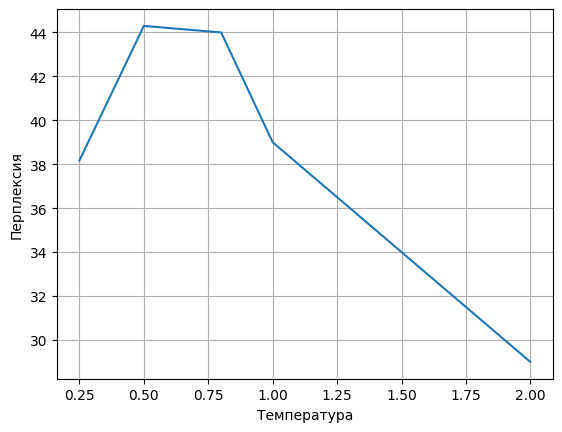

In [ ]:
plt.plot(temp, perplexity_temp)
plt.xlabel('Температура')
plt.ylabel('Перплексия')
plt.grid()

**Генерация текстов разной длины**

In [ ]:
text_1 = generate_text(model, u"He said ", 0.5, 50)

In [ ]:
text_1

'He said the counded reait and that I had be ne, when the s'

In [ ]:
text_2 = generate_text(model, u"She thinks ", 0.5, 100)

In [ ]:
text_2

'She thinks be any the counder. I didnt the lang a little but of the side be any to go to a strained to in the s'

In [ ]:
text_3 = generate_text(model, u"In my younger ", 0.5, 150)

In [ ]:
text_3

'In my younger and the care on the singersting to a sid that I want that and which every, and for a cound into the counded to see tounding armusting of the dicage an'

In [ ]:
text_4 = generate_text(model, u"I never ", 0.5, 250)

In [ ]:
text_4

'I never a letter on the doom of the come to a scared a down her over the traingly a cound the a strance to the sain to as the had and the and the car she out the one on the seement would and the for a said I her as he cound and\rseemed to go as the and the ca'

In [ ]:
text_5 = generate_text(model, u"I never ", 0.5, 500)

In [ ]:
text_5

'I never the sobech after be and ever by this in his and shore and to he was to got that with a seren of that we were a little beant a could the and when I had be a strained the counded an the compled by a would of his naid.\r\rWhen I had the door on the saw he supped but the reame that I see that the cound to a sound to to of him before and was a man and the that I was an the wirned the before with the litt was and down the seef of the all the sevented but the could to a\rfare in a chort that ever the darn'

In [ ]:
corpus = text_1

n = 2
ngram_counts = Counter(ngrams(corpus.split(), n))

total_count = sum(ngram_counts.values())
probabilities = {ngram: count/total_count for ngram, count in ngram_counts.items()}


In [ ]:
probs = []

In [ ]:
print("Вероятности биграмм:")
for ngram, prob in probabilities.items():
    print(' '.join(ngram), "->", prob)
    probs.append(prob)

Вероятности биграмм:
He said -> 0.07692307692307693
said the -> 0.07692307692307693
the counded -> 0.07692307692307693
counded reait -> 0.07692307692307693
reait and -> 0.07692307692307693
and that -> 0.07692307692307693
that I -> 0.07692307692307693
I had -> 0.07692307692307693
had be -> 0.07692307692307693
be ne, -> 0.07692307692307693
ne, when -> 0.07692307692307693
when the -> 0.07692307692307693
the s -> 0.07692307692307693


In [ ]:
probabilities = probs

In [ ]:
perplexity_1 = calculate_perplexity(probabilities)
print("Perplexity:", perplexity_1)

Perplexity: 12.999999999999993


In [ ]:
corpus = text_2

n = 2
ngram_counts = Counter(ngrams(corpus.split(), n))

total_count = sum(ngram_counts.values())
probabilities = {ngram: count/total_count for ngram, count in ngram_counts.items()}


In [ ]:
probs = []

In [ ]:
print("Вероятности биграмм:")
for ngram, prob in probabilities.items():
    print(' '.join(ngram), "->", prob)
    probs.append(prob)

Вероятности биграмм:
She thinks -> 0.038461538461538464
thinks be -> 0.038461538461538464
be any -> 0.07692307692307693
any the -> 0.038461538461538464
the counder. -> 0.038461538461538464
counder. I -> 0.038461538461538464
I didnt -> 0.038461538461538464
didnt the -> 0.038461538461538464
the lang -> 0.038461538461538464
lang a -> 0.038461538461538464
a little -> 0.038461538461538464
little but -> 0.038461538461538464
but of -> 0.038461538461538464
of the -> 0.038461538461538464
the side -> 0.038461538461538464
side be -> 0.038461538461538464
any to -> 0.038461538461538464
to go -> 0.038461538461538464
go to -> 0.038461538461538464
to a -> 0.038461538461538464
a strained -> 0.038461538461538464
strained to -> 0.038461538461538464
to in -> 0.038461538461538464
in the -> 0.038461538461538464
the s -> 0.038461538461538464


In [ ]:
probabilities = probs

In [ ]:
perplexity_2 = calculate_perplexity(probabilities)
print("Perplexity:", perplexity_2)

Perplexity: 25.28902863271946


In [ ]:
corpus = text_3

n = 2
ngram_counts = Counter(ngrams(corpus.split(), n))

total_count = sum(ngram_counts.values())
probabilities = {ngram: count/total_count for ngram, count in ngram_counts.items()}


In [ ]:
probs = []

In [ ]:
print("Вероятности биграмм:")
for ngram, prob in probabilities.items():
    print(' '.join(ngram), "->", prob)
    probs.append(prob)

Вероятности биграмм:
In my -> 0.030303030303030304
my younger -> 0.030303030303030304
younger and -> 0.030303030303030304
and the -> 0.030303030303030304
the care -> 0.030303030303030304
care on -> 0.030303030303030304
on the -> 0.030303030303030304
the singersting -> 0.030303030303030304
singersting to -> 0.030303030303030304
to a -> 0.030303030303030304
a sid -> 0.030303030303030304
sid that -> 0.030303030303030304
that I -> 0.030303030303030304
I want -> 0.030303030303030304
want that -> 0.030303030303030304
that and -> 0.030303030303030304
and which -> 0.030303030303030304
which every, -> 0.030303030303030304
every, and -> 0.030303030303030304
and for -> 0.030303030303030304
for a -> 0.030303030303030304
a cound -> 0.030303030303030304
cound into -> 0.030303030303030304
into the -> 0.030303030303030304
the counded -> 0.030303030303030304
counded to -> 0.030303030303030304
to see -> 0.030303030303030304
see tounding -> 0.030303030303030304
tounding armusting -> 0.030303030303030304


In [ ]:
probabilities = probs

In [ ]:
perplexity_3 = calculate_perplexity(probabilities)
print("Perplexity:", perplexity_3)

Perplexity: 33.00000000000004


In [ ]:
corpus = text_4

n = 2
ngram_counts = Counter(ngrams(corpus.split(), n))

total_count = sum(ngram_counts.values())
probabilities = {ngram: count/total_count for ngram, count in ngram_counts.items()}


In [ ]:
probs = []

In [ ]:
print("Вероятности биграмм:")
for ngram, prob in probabilities.items():
    print(' '.join(ngram), "->", prob)
    probs.append(prob)

Вероятности биграмм:
I never -> 0.016129032258064516
never a -> 0.016129032258064516
a letter -> 0.016129032258064516
letter on -> 0.016129032258064516
on the -> 0.03225806451612903
the doom -> 0.016129032258064516
doom of -> 0.016129032258064516
of the -> 0.016129032258064516
the come -> 0.016129032258064516
come to -> 0.016129032258064516
to a -> 0.016129032258064516
a scared -> 0.016129032258064516
scared a -> 0.016129032258064516
a down -> 0.016129032258064516
down her -> 0.016129032258064516
her over -> 0.016129032258064516
over the -> 0.016129032258064516
the traingly -> 0.016129032258064516
traingly a -> 0.016129032258064516
a cound -> 0.016129032258064516
cound the -> 0.016129032258064516
the a -> 0.016129032258064516
a strance -> 0.016129032258064516
strance to -> 0.016129032258064516
to the -> 0.016129032258064516
the sain -> 0.016129032258064516
sain to -> 0.016129032258064516
to as -> 0.016129032258064516
as the -> 0.03225806451612903
the had -> 0.016129032258064516
had and

In [ ]:
probabilities = probs

In [ ]:
perplexity_4 = calculate_perplexity(probabilities)
print("Perplexity:", perplexity_4)

Perplexity: 58.27925766886096


In [ ]:
corpus = text_5

n = 2
ngram_counts = Counter(ngrams(corpus.split(), n))

total_count = sum(ngram_counts.values())
probabilities = {ngram: count/total_count for ngram, count in ngram_counts.items()}


In [ ]:
probs = []

In [ ]:
print("Вероятности биграмм:")
for ngram, prob in probabilities.items():
    print(' '.join(ngram), "->", prob)
    probs.append(prob)

Вероятности биграмм:
I never -> 0.00847457627118644
never the -> 0.00847457627118644
the sobech -> 0.00847457627118644
sobech after -> 0.00847457627118644
after be -> 0.00847457627118644
be and -> 0.00847457627118644
and ever -> 0.00847457627118644
ever by -> 0.00847457627118644
by this -> 0.00847457627118644
this in -> 0.00847457627118644
in his -> 0.00847457627118644
his and -> 0.00847457627118644
and shore -> 0.00847457627118644
shore and -> 0.00847457627118644
and to -> 0.00847457627118644
to he -> 0.00847457627118644
he was -> 0.00847457627118644
was to -> 0.00847457627118644
to got -> 0.00847457627118644
got that -> 0.00847457627118644
that with -> 0.00847457627118644
with a -> 0.00847457627118644
a seren -> 0.00847457627118644
seren of -> 0.00847457627118644
of that -> 0.00847457627118644
that we -> 0.00847457627118644
we were -> 0.00847457627118644
were a -> 0.00847457627118644
a little -> 0.00847457627118644
little beant -> 0.00847457627118644
beant a -> 0.00847457627118644
a 

In [ ]:
probabilities = probs

In [ ]:
perplexity_5 = calculate_perplexity(probabilities)
print("Perplexity:", perplexity_5)

Perplexity: 114.43584899950885


In [ ]:
perplexity_len = [perplexity_1, perplexity_2, perplexity_3, perplexity_4, perplexity_5]

In [ ]:
len = [50,100,150,250,500]

In [ ]:
perplexity_len

[12.999999999999993,
 25.28902863271946,
 33.00000000000004,
 58.27925766886096,
 114.43584899950885]

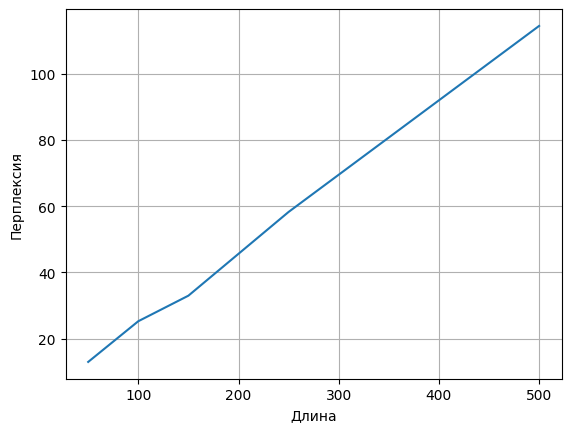

In [ ]:
plt.plot(len, perplexity_len)
plt.xlabel('Длина')
plt.ylabel('Перплексия')
plt.grid()

Определение потерь

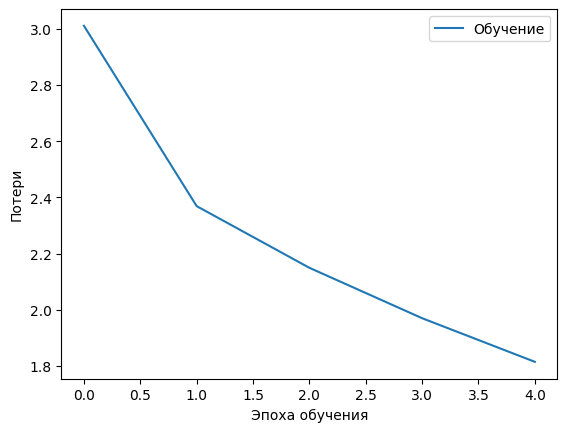

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = 'Обучение')
plt.xlabel('Эпоха обучения')
plt.ylabel('Потери')
plt.legend()
plt.show()